## Expandable, fully-connected network
A quick and dirty implementation of the Belkin paper

Get the 'pickled' MNIST dataset from http://deeplearning.net/data/mnist/mnist.pkl.gz. We're going to treat it as a standard flat dataset with fully connected layers, rather than using a CNN.

In [1]:
%matplotlib inline
from fastai.basics import *
import torch
import torch.nn.functional as F
import typing

In [2]:
path = Config().data_path()/'mnist'

In [3]:
with gzip.open(path/'mnist.pkl.gz', 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

In [4]:
# the images are imported as a vector, so need reshaping to be viewed
def show_image(x):
    plt.imshow(x.reshape((28,28)), cmap="gray")

In [5]:
x_train,y_train,x_valid,y_valid = map(torch.tensor, (x_train,y_train,x_valid,y_valid))
n, c = x_train.shape
print("Number of training examples: {}\nNumber of features: {}".format(n, c))

Number of training examples: 50000
Number of features: 784


In [6]:
# this has to be the lightest way of creating a DataBunch
bs=32
train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)
data = DataBunch.create(train_ds, valid_ds, bs=bs)

In [7]:
x, y = next(iter(data.train_dl))
x.shape, y.shape

(torch.Size([32, 784]), torch.Size([32]))

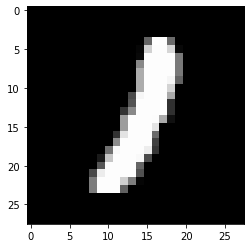

In [8]:
show_image(x[8])

In [ ]:
class FullyConnected(nn.Module):
    def __init__(self, n_layers=32, layer_width=16):
        super().__init__()
        self.n_layers = n_layers
        self.layer_width = layer_width
        self.input_layer = nn.Linear(784, self.layer_width)
        self.output = nn.Linear(16,10)

    def forward(self, X): 
        X = F.relu(self.input_layer(X))
        return F.relu(self.output(X))

In [ ]:
model = FullyConnected(n_layers=1)
model

In [9]:
lr=2e-3
loss_function = nn.CrossEntropyLoss()

In [31]:
def update(x, y, lr):
    optimiser = optim.Adam(model.parameters(), lr, weight_decay=.05)
    y_hat = model(x)
    loss = loss_function(y_hat, y)
    loss.backward()
    optimiser.step()
    optimiser.zero_grad()
    return loss.item()

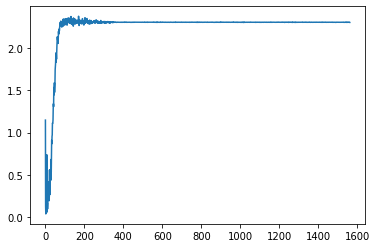

In [22]:
losses = [update(x, y, lr) for x, y in data.train_dl]
plt.plot(losses);

In [ ]:
def show_and_tell(idx):
    show_image(x[idx])
    prediction = torch.argmax( model(x[idx]) ).item()
    print("Predicted digit: {}".format(prediction))

In [ ]:
show_and_tell(12)

In [ ]:
class ExpandableFullyConnected(nn.Module):
    def __init__(self, n_layers=32, layer_width=16):
        super().__init__()
        self.n_layers = n_layers
        self.layer_width = layer_width
        self.input_layer = nn.Linear(784, self.layer_width)
        self.hidden_layers = nn.ModuleList([nn.Linear(self.layer_width, self.layer_width, bias=True)] * n_layers)
        self.output = nn.Linear(16,10)

    def forward(self, X): 
        X = F.relu(self.input_layer(X))
        for layer in self.hidden_layers:
            X = F.relu( layer(X) )
        return F.relu(self.output(X))
    
    

In [ ]:
model = ExpandableFullyConnected(n_layers=1)

In [ ]:
print("First five layers of hidden layer stack:")
model.hidden_layers[:5]

In [ ]:
losses = [update(x, y, lr) for x, y in data.train_dl]
plt.plot(losses);

In [ ]:
show_and_tell(12)

In [ ]:
model = ExpandableFullyConnected(n_layers=1, layer_width=16)

In [ ]:
losses = [update(x, y, lr) for x, y in data.train_dl]
plt.plot(losses);

Try using Sequential:

In [23]:
def create_multilayer_perceptron(n_hidden, hidden_width):
    layers = [("input", nn.Linear(784, hidden_width)), ('relu1', nn.ReLU())]
    for i in range(n_hidden):
        layer_name = "hidden" + str(i)
        layers.append((layer_name, nn.Linear(hidden_width, hidden_width)))

    layers.append(("output", nn.Linear(hidden_width, 10)))
    return ( nn.Sequential(OrderedDict(layers)))

In [32]:
model = create_multilayer_perceptron(2, 64)

In [33]:
model

Sequential(
  (input): Linear(in_features=784, out_features=64, bias=True)
  (relu1): ReLU()
  (hidden0): Linear(in_features=64, out_features=64, bias=True)
  (hidden1): Linear(in_features=64, out_features=64, bias=True)
  (output): Linear(in_features=64, out_features=10, bias=True)
)

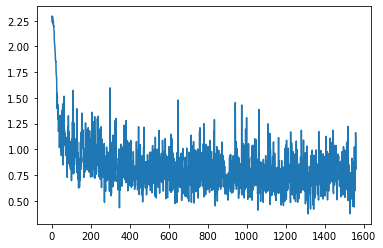

In [34]:
losses = [update(x, y, lr) for x, y in data.train_dl]
plt.plot(losses);